In [1]:
%load_ext autoreload
%autoreload 2

In [58]:
# setting project path
import os
import sys

gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# imports
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

from src import classes as c
from src import functions as f
import matplotlib.pyplot as plt
import seaborn as sns

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')

## Importing the Data

In [3]:
path = os.path.join(gparent, 'data/processed', 'modeling.csv')
df = pd.read_csv(path, keep_default_na=False)

## Preprocessing and Harness Objects

In [4]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

In [5]:
preprocessing = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))

In [6]:
sm = SMOTE(random_state=2021)

In [7]:
# creating f1 scorer
f1 = f.f1

In [8]:
modeling = c.Harness(f1)

## Baseline Model

Dropping engineered features to establish the baseline score.

In [9]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [44]:
excluded = ['Weapon Type', 'Officer ID', 'Initial Call Type', 'Final Call Type',
             'Call Type', 'Officer Squad', 'Arrest Flag',
             'Frisk Flag',  'Sector', 'Beat', 'Weapon Flag',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

In [45]:
baseline_df = f.framer(df, [], excluded)

In [46]:
baseline_df.head(2)

,Target,Subject Age Group,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Precinct
0,1,NA,1984,M,Black,Asian,Male,South
1,0,NA,1965,M,White,NA,NA,NA


In [47]:
baseline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46960 entries, 0 to 46959
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Target                    46960 non-null  int64 
 1   Subject Age Group         46960 non-null  object
 2   Officer YOB               46960 non-null  int64 
 3   Officer Gender            46960 non-null  object
 4   Officer Race              46960 non-null  object
 5   Subject Perceived Race    46960 non-null  object
 6   Subject Perceived Gender  46960 non-null  object
 7   Precinct                  46960 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.9+ MB


In [48]:
X, y = f.Xy(baseline_df)

In [49]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [50]:
preprocessing.fit_transform(X_train)

<35220x42 sparse matrix of type '<class 'numpy.float64'>'
	with 246540 stored elements in Compressed Sparse Row format>

In [51]:
KNN = KNeighborsClassifier()

In [52]:
baseline = make_pipeline(preprocessing, KNN)

In [53]:
modeling.report(baseline, X_train, y_train, 'Baseline', 'KNN - Baseline Features')

Baseline has an average F1 of 0.2930510571694175


array([0.29814942, 0.28491425, 0.29144667, 0.30731877, 0.28342618])

In [54]:
baseline_sm = make_sm_pipeline(preprocessing, sm, KNN)

In [55]:
modeling.report(baseline_sm, X_train, y_train, 'Baseline_SM',\
                'Baseline Model w/ SMOTE')

Baseline_SM has an average F1 of 0.4185201782434615


array([0.41236183, 0.41164703, 0.43376213, 0.40610061, 0.42872928])

With OID:
0.4344416 , 0.44728326, 0.44414215, 0.42996076, 0.43894279

In [21]:
# f.confusion(baseline, X_train, y_train)

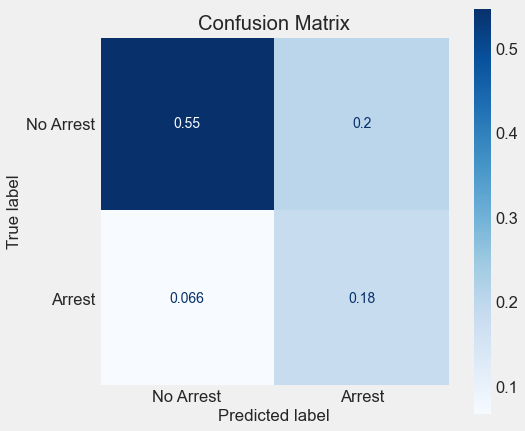

In [57]:
f.confusion(baseline_sm, X_train, y_train)

In [56]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.223515,Log Reg Baseline
1,Baseline,0.293051,KNN - Baseline Features
2,Baseline,0.331348,KNN - Baseline Features
5,Baseline_SM,0.418520,Baseline Model w/ SMOTE
3,Baseline_SM,0.438954,Baseline Model w/ SMOTE
4,LR SMOTE,0.489565,Log Reg w/ SMOTE


## KNN With Engineered Features
Engineered columns from original EDA:

'Weapon Flag', 'Reported Year', 'Reported Month', 'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag'

In [24]:
feature_list1 = ['Sector',
 'Beat',
 'Weapon Flag',
 'Reported Year',
 'Reported Month',
 'Day of Month',
 'Day of Week',
 'Reported Hour',
 'Beat Flag']

In [25]:
excluded1 = ['Weapon Type',
 'Initial Call Type',
 'Final Call Type',
 'Call Type',
 'Officer Squad',
 'Arrest Flag',
 'Frisk Flag',]

In [26]:
engineered = f.framer(df, feature_list1, excluded1)

In [27]:
f.feature_test(engineered, KNN, feature_list1)

KNeighborsClassifier() Sector Model has an average F1 of 0.4438066252983954
KNeighborsClassifier() Beat Model has an average F1 of 0.44520790560466983
KNeighborsClassifier() Weapon Flag Model has an average F1 of 0.4427578497741777
KNeighborsClassifier() Reported Year Model has an average F1 of 0.46522523489066947
KNeighborsClassifier() Reported Month Model has an average F1 of 0.4570336046505437
KNeighborsClassifier() Day of Month Model has an average F1 of 0.4577019175646882
KNeighborsClassifier() Day of Week Model has an average F1 of 0.45348989395767686
KNeighborsClassifier() Reported Hour Model has an average F1 of 0.46134833403225634
KNeighborsClassifier() Beat Flag Model has an average F1 of 0.4370862225309661


,Name,Accuracy,Notes
8,KNeighborsClassifier() Beat Flag Model,0.437086,Beat Flag added
0,KNeighborsClassifier() Weapon Flag Model,0.442758,Weapon Flag added
1,KNeighborsClassifier() Sector Model,0.443807,Sector added
2,KNeighborsClassifier() Beat Model,0.445208,Beat added
3,KNeighborsClassifier() Day of Week Model,0.453490,Day of Week added
4,KNeighborsClassifier() Reported Month Model,0.457034,Reported Month added
5,KNeighborsClassifier() Day of Month Model,0.457702,Day of Month added
6,KNeighborsClassifier() Reported Hour Model,0.461348,Reported Hour added
7,KNeighborsClassifier() Reported Year Model,0.465225,Reported Year added


## Logistic Regression Baseline

In [59]:
# features engineered during eda
feature_list2 = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [60]:
excluded2 = ['Weapon Type', 'Officer ID', 'Initial Call Type', 'Final Call Type',
             'Call Type', 'Officer Squad', 'Arrest Flag',
             'Frisk Flag',  'Sector', 'Beat', 'Weapon Flag',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

In [61]:
baseline_df1 = f.framer(df, [], excluded2)

In [62]:
baseline_df1.head(2)

,Target,Subject Age Group,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Precinct
0,1,NA,1984,M,Black,Asian,Male,South
1,0,NA,1965,M,White,NA,NA,NA


In [63]:
X, y = f.Xy(baseline_df1)

In [64]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [65]:
preprocessing.fit_transform(X_train);

In [66]:
LR = LogisticRegression(max_iter=1000)

In [67]:
baseline_LR = make_pipeline(preprocessing, LR)

In [37]:
modeling.report(baseline_LR, X_train, y_train, 'LR Baseline',\
                'Log Reg Baseline')

LR Baseline has an average F1 of 0.22351468310274009


array([0.2244898 , 0.22162884, 0.21597096, 0.24177778, 0.21370604])

In [38]:
lr_smote = make_sm_pipeline(preprocessing, sm, LR)

In [68]:
modeling.report(lr_smote, X_train, y_train, 'LR SMOTE', 'Log Reg w/ SMOTE')

LR SMOTE has an average F1 of 0.4782273316755937


array([0.47928701, 0.47294003, 0.48095002, 0.47984072, 0.47811888])

In [69]:
f.feature_test(engineered, LR, feature_list1)

LogisticRegression(max_iter=1000) Sector Model has an average F1 of 0.49372091753402997
LogisticRegression(max_iter=1000) Beat Model has an average F1 of 0.490860176583577
LogisticRegression(max_iter=1000) Weapon Flag Model has an average F1 of 0.495054870258443
LogisticRegression(max_iter=1000) Reported Year Model has an average F1 of 0.4916057185813131
LogisticRegression(max_iter=1000) Reported Month Model has an average F1 of 0.4915830283639665
LogisticRegression(max_iter=1000) Day of Month Model has an average F1 of 0.49079264892083935
LogisticRegression(max_iter=1000) Day of Week Model has an average F1 of 0.4893853867191951
LogisticRegression(max_iter=1000) Reported Hour Model has an average F1 of 0.49070619417441713
LogisticRegression(max_iter=1000) Beat Flag Model has an average F1 of 0.4917069342339889


,Name,Accuracy,Notes
0,LogisticRegression(max_iter=1000) Day of Week ...,0.489385,Day of Week added
1,LogisticRegression(max_iter=1000) Reported Hou...,0.490706,Reported Hour added
2,LogisticRegression(max_iter=1000) Day of Month...,0.490793,Day of Month added
3,LogisticRegression(max_iter=1000) Beat Model,0.490860,Beat added
4,LogisticRegression(max_iter=1000) Reported Mon...,0.491583,Reported Month added
5,LogisticRegression(max_iter=1000) Reported Yea...,0.491606,Reported Year added
8,LogisticRegression(max_iter=1000) Beat Flag Model,0.491707,Beat Flag added
6,LogisticRegression(max_iter=1000) Sector Model,0.493721,Sector added
7,LogisticRegression(max_iter=1000) Weapon Flag ...,0.495055,Weapon Flag added


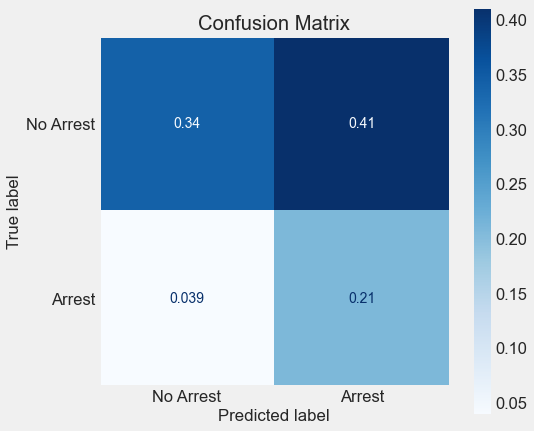

In [70]:
f.confusion(lr_smote, X_train, y_train)